# Sentiment Analysis on Amazon Review Data with LSTM
##  Using Tensorflow and Keras

### Description
The aim of Sentiment Analysis is to computationally identify and categorize opinions expressed in a piece of text. Instead of classifing each piece of text as Positive, Negative or Neutral, the model assings a predicted score from 1 to 5 indicating the number of stars that a user would give to a product after writig a certain review.

The datasets used can be found at the following link:
* [Amazon Datasets](https://nijianmo.github.io/amazon/index.html#subsets)


In [ ]:
import numpy as np
import pandas as pd
import re
import time
from termcolor import colored
import string
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten,Activation
from keras import optimizers
from keras.callbacks import EarlyStopping
import warnings
from gensim.models import Word2Vec, KeyedVectors

In [2]:
df_software = pd.read_json('data/Software_5.json', lines = True, encoding='utf-8')
df_science = pd.read_json('data/Industrial_and_Scientific_5.json', lines = True,encoding='utf-8')

In [3]:
df = pd.concat([df_software, df_science])

Data overview. We will only be using the <font color=red>**'overall'**</font> and the <font color=red>**'reviewText'**</font> fieds.

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"10 20, 2010",A38NELQT98S4H8,0321719816,{'Format:': ' DVD-ROM'},WB Halper,I've been using Dreamweaver (and it's predeces...,A solid overview of Dreamweaver CS5,1287532800,NaN,NaN
1,4,False,"10 18, 2010",A3QJU4FEN8PQSZ,0321719816,{'Format:': ' DVD-ROM'},Grimmy,"The demo is done with the PC version, with ref...",A good value,1287360000,NaN,NaN
2,5,False,"10 16, 2010",ACJT8MUC0LRF0,0321719816,{'Format:': ' DVD-ROM'},D. Fowler,If you've been wanting to learn how to create ...,This is excellent software for those who want ...,1287187200,3,NaN
3,5,False,"10 12, 2010",AYUF7YETYOLNX,0321719816,{'Format:': ' DVD-ROM'},Bryan Newman,I've been creating websites with Dreamweaver f...,A Fantastic Overview of Dream Weaver and Web D...,1286841600,NaN,NaN
4,5,False,"10 7, 2010",A31ICLWQ9CSHRS,0321719816,{'Format:': ' DVD-ROM'},Al Swanson,I decided (after trying a number of other prod...,Excellent Tutorials!,1286409600,NaN,NaN


In [5]:
df_text = df['reviewText'].values
df_score = df['overall'].values

Removing the lines with an empy review field (<font color='red'>"nan"</font>).

In [6]:
text = []
score = []
c = 0 

for i in range(len(df_text)):
    if str(df_text[i]) != "nan":
        text.append(df_text[i])
        score.append(df_score[i])
    else:
        c += 1
#         print(i)

Function to clean the text of the reviews using regular expressions. Return the clean text all in lower case.

In [7]:
def cleanText(string):
    string = re.sub(r"[-()\"#/@;:<>{}+=./|.!?,~]", "", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [8]:
cleanT = []
for t in text:
    cleanT.append(cleanText(t))

**Stop Words** usually return a lot of unecessary information (**'this', 'that', 'at', 'and'**). For this classification taskit is ok to exclude them from our dictionary. In other applications like Chat-Bots and Generative models they are usually not excluded as they help generating more "natural" looking languange.

In [9]:
stop_words =  ['if', 'do', '\'ve' , 'program' , 'window',  'windows', 'even' ,  'computer' ,'product' ,'\'ll' , 'use', 'used', 'one' ,'n\'t' , '\'re' , '\'s' ,'few', "it's", "shouldn't", 'myself', 'its', 'has', 'with', 'been', 'can', 'won', "you'll", 'below', "weren't", 'into', 'him', 'this', 'above', 'our', "needn't", 'here', 'i', 'me', 'all', 're', "won't", 'don', 'should', 'such', 'or', 'for', "couldn't", 'what', "should've", 'does', 'hers', 'other', "that'll", "doesn't", "wasn't", 'once', 'while', 'between', 'mightn', "hasn't", 'too', 'up', 'before', 'their', 'himself', 'it', "you'd", 'some', 'themselves', 'ain', 'an', 'ours', 'at', 'haven', 'about', 'just', 'shouldn', 'o', 'both', 'out', "isn't", 'll', 'ma', 'you', "haven't", 'only', 'hadn', 'those', 'they', 'against', 'down', 'over', 't', 'she', 'again', 'why', 'did', 'wouldn', 'a', 'when', 'your', 'ourselves', 'who', 'having', 'on', 'y', 'theirs', 'being', 'herself', 'nor', 'that', 'by', "don't", "mustn't", "shan't", 'because', 'not', 'under', 'are', 'he', 'own', "you've", 'there', 'yours', 'and', 'most', "mightn't", 'have', 'doing', 'during', 'couldn', "didn't", 'will', 'weren', 'd', 'were', "she's", "wouldn't", 'isn', 'then', 'doesn', 'wasn', 'itself', 'now', 'didn', 'these', 'them', 'needn', 'yourself', 'shan', 'is', 'more', 'be', "you're", 'than', 'after', 'aren', 'how', 'where', 'which', 'in', "hadn't", 'further', 'no', 'yourselves', 'as', 'whom', 'to', 'hasn', 'mustn', 'through', 'the', 'm', 's', 'very', 'we', 'each', 'until', 'same', "aren't", 'was', 'my', 'so', 'from', 've', 'am', 'had', 'his', 'but', 'off', 'any', 'of', 'her']
punctuation = list(string.punctuation)
stop = stop_words + punctuation

In [10]:
clean_text = []

for s in cleanT:
    sentence = s
    sent_words = sentence.split()
    words = [i for i in sent_words if i not in stop]
    output = ' '.join(words)
    clean_text.append(output)

Dividing reviews in **Positive** and **Negative** in order to show the most reoccuring words in each case.

In [11]:
positive_reviews = []
positive_score = []
negative_reviews = []
negative_score = []

for i in range(len(score)):
    if score[i] == 5:
        positive_reviews.append(clean_text[i])
        positive_score.append(score[i])
    elif score[i] == 1:
        negative_reviews.append(clean_text[i])
        negative_score.append(score[i])

In [12]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(str(data))
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color=color, width=2500, height=2000).generate(data)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [127]:
negative_words = ""

for i in range(len(negative_reviews)):
    negative_words += str(negative_reviews[i])

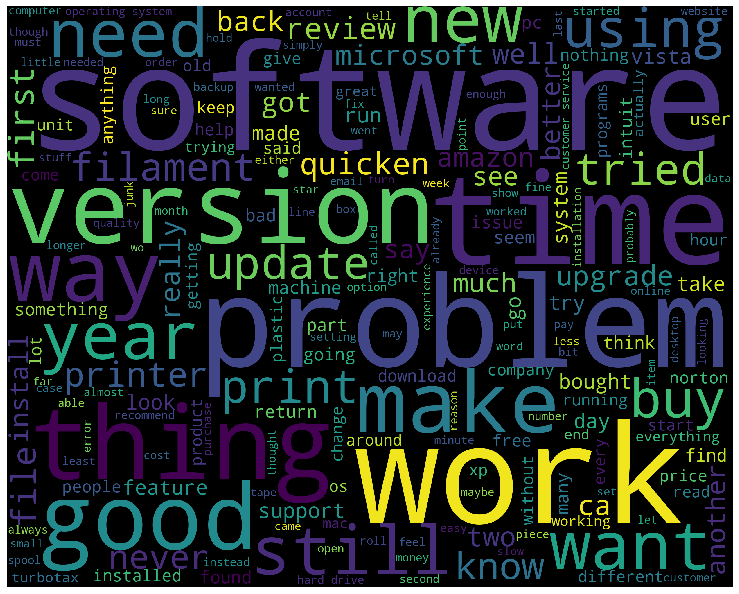

In [128]:
wordcloud_draw(negative_words)

In [129]:
positive_words = ""

for i in range(len(positive_reviews[0:1000])):
    positive_words += str(positive_reviews[i])

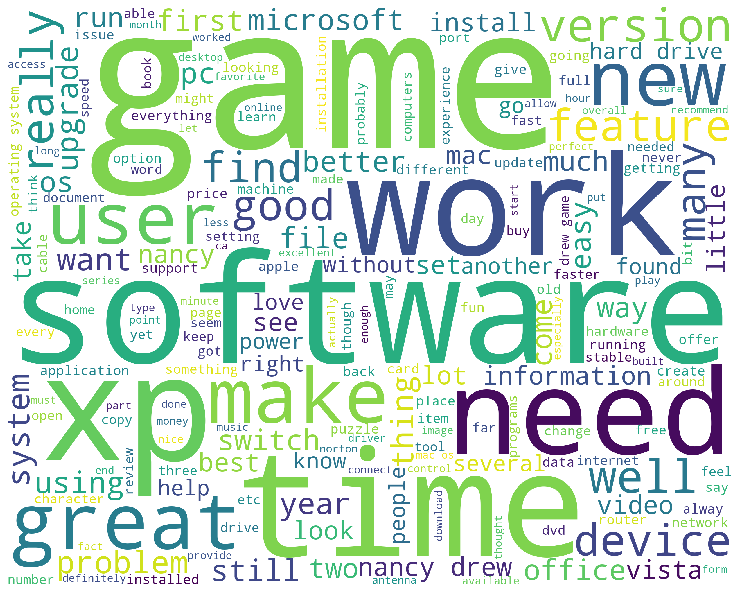

In [130]:
wordcloud_draw(positive_words, 'white')

Splitting the data into Training and Testing using **sklearn**.

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(clean_text, score, test_size = 0.3 , random_state = 0)

The first layer of the LSTM model will be an **Embedding Layer**. This layer allows us to have a vectorized representation of words which will be then be able to be fed into the model. 

Here I am using **Gensim** *Word2Vec* embedding to give an example of what a vectorized representation of words allows us to do. For instnace, it is possible to find words that have a similar meaning and that is based on the context in which said words appear in.

* [Gensim Documentation](https://radimrehurek.com/gensim/auto_examples/index.html)

In [14]:
corpus = []

for review in X_train:
    sent_words = review.split()
#     print(list(sent_words))
    corpus.append(list(sent_words))
# print(corpus)

In [15]:
model = Word2Vec(corpus,min_count=1,size=200)

In [16]:
model.wv.most_similar('good')

[('decent', 0.8506947755813599),
 ('excellent', 0.7225998640060425),
 ('great', 0.7004508972167969),
 ('stetsbut', 0.6984545588493347),
 ('amazing', 0.6817405819892883),
 ('lessor', 0.6727639436721802),
 ('fantastic', 0.6711835861206055),
 ('awesome', 0.6668567657470703),
 ('fair', 0.6666578650474548),
 ('bad', 0.6645188927650452)]

The **Y Data** which contains the scores assigned to reviews gets **One-Hot Encoded**. Because we only have 5 possible classes (scores range from 1 to 5), the ouput will have shape **(num_reviews, num_classes)**.

In [17]:
def encodeData(y):
        y = np.reshape(y, (-1, 1))
        onehotencoder  =  OneHotEncoder()
        y = onehotencoder.fit_transform(y).toarray()
        return y

In [18]:
warnings.simplefilter(action='ignore', category=FutureWarning)
y_train = encodeData(Y_train)
y_test = encodeData(Y_test)

In [19]:
print(y_train.shape)
print(y_train[0:5])
print(y_test.shape)
print(y_test[0:5])

(62904, 5)
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
(26960, 5)
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [20]:
classes = np.unique(score)
print(classes)
num_classes = len(classes)
print(num_classes)

[1 2 3 4 5]
5


The next and last step in Data Preprocessing is to **tokenize** and **pad** the X Data which contains the review text.

I am using **Keras** *Tokenizer* and *Pad Sequence* functions. I am only choosing to tokenize and keep the 50000 most reoccuring words to avoid any **memory issues** and setting the max length of each review to 50 characters. After the tokenizer is fitted to the data, each **word** will be **replaced** by the **integer** corresponding to the frequency of that word appearing in the data.

The padding, which consists in adding zeroes to a review until it reachs 50 characters will be applied at the end of the string (**Post**).

In [21]:
def tokenizeData(data ,X, max_words, maxlen):
        
        max_words = max_words

        # Tokenisation and making data into a LIST
        tokenizer = Tokenizer(num_words = max_words)
        tokenizer.fit_on_texts(data)
        X = tokenizer.texts_to_sequences(X)

        maxlen = maxlen

        X = pad_sequences(X, padding='post', maxlen=maxlen)

        return X

In [22]:
max_words = 50000
max_len = 50

x_train = tokenizeData(clean_text, X_train, max_words, max_len)
x_test = tokenizeData(clean_text, X_test, max_words, max_len)

In [23]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0.0001)

The next step is to define the model. I chose to use an **LSTM** (**Long-Short Term Memory**).

**LSTM** is an artificial **Recurrent Neural Network** architecture which is mainly used when dealing with **sequential data**. The main difference with **Feed Forward Neural Networs** is the presence of *feedback connections*. This architecture can be used to classify, cluster and make predictions about data.

For this project I've used [Keras Sequential Model API](https://keras.io/models/sequential/).

The model is formed by four layer:
* **Embedding Layer**: used to convert the tokenized reviews into dense vectors that can be fed into the next layer. **max_words** is the number of tokenized words which I have set to 50000, 50 is the size of the output dimension of the dense embedding and **max_len** is the maximum length of each review which I have also set to 50.
* **LSTM Layer**: long-short term memory layer. The default activation function for this layer is **tanh**. The parameter **lstm_out** is the dimensionality of the output space. The **dropout rate** was set to **0.2** for both the  the linear transformation of the **inputs** and the  the linear transformation of **recurrent states**.
* **Dense Layer**: the last Dense layer is the output layer. This layer, which size is equal to the umber of unique classes available (5) has a **Softmax activation function**. The output of this layer will be equal to a normalized probability distribution over the classes we are trying to classify the input in. The class that has the highest probability will be the one determining the score assigned to a review.

**Objective Function**: **Categorical Cross Entropy** Compares the distribution of the predictions given by the output layer activation function (Softmax) with the true distribution where the probability of the correct class is set to 1 and all the others to 0.

**Optimizer**: **Adam**, computes the weight change amount used in backpropagation by using an Adaptive Learning Rate through the use of moment estimation.

The function will return the model which can then be used to predict the score of unseen reviews later on.

All of the parameters used can be tuned and changed to achieve a better model performance. Feel free to play around with them.

In [24]:
def lstmModel(X_Train, X_Test, Y_Train, Y_Test, num_classes, epochs, batch_size):
    lstm_out = 196
    model = Sequential()
    model.add(Embedding(max_words, 50, input_length=max_len))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
#     adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(np.array(X_Train), np.array(Y_Train), batch_size = batch_size, epochs = epochs, verbose = 1, validation_split=0.1)
    
    score = model.evaluate(np.array(X_Test), np.array(Y_Test), batch_size = batch_size, verbose = 1)
    loss, accuracy = model.evaluate(X_Train, Y_Train, verbose=False)
    print('training loss: {}'.format(loss))
    print('training accuracy: {}'.format(accuracy))
    print('test loss: {}'.format(score[0]))
    print('test accuracy: {}'.format(score[1]))
    print(score)
    print(len(X_test) * score[1], '/', len(X_test) )
    return model

The model was trained for **10 epochs** and the **batch size** was set to **64**. 

In [26]:
start = time.time()

epochs = 10
batch_size = 64
warnings.simplefilter("ignore", UserWarning)
LSTM = lstmModel(x_train, x_test, y_train, y_test, num_classes, epochs, batch_size)

end = time.time()
print('TIME (minutes) = ', (end - start)/60, ' (', (end - start) ,'s)')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 50)            2500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               193648    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 985       
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 2,694,633
Trainable params: 2,694,633
Non-trainable params: 0
_________________________________________________________________
Train on 56613 samples, validate on 6291 samples
Epoch 1/10
56613/56613 [==============================] - 358s 6ms/step - loss: 0.9027 - accuracy: 0.6948 - val_loss: 0.8194 - val_accuracy: 0.7072
Epoch 2/10
56613/56613 [=====================

The results are as follows:
* ***Training Data***:
    * **Accuracy**: 0.87
    * **Loss**: 0.41
* ***Testing Data***:
    * **Accuracy**: 0.71
    * **Loss**: 0.92
    * The model was able to **correctly classify** $19171$ out of $26960$ unseen reviews.

After the model was trained, I tested it on three different fake reviews. The model assigned a score to each of them.

* The two **bad reviews** both scored **2/5**
* The **excellent** review score a **5/5**

Even if a review can be interpreted differently by different idividuals, the model was able to assign a pretty accurate score to all three of them.

In [27]:
bad_review = 'This product is not the best, there are some problems with the intallation and the overall experience was terrible. Would not recommend this product to anyone'
clean_review = []
clean_review.append(cleanText(bad_review))
print(clean_review)
bad_review = tokenizeData(clean_text, clean_review, max_words, max_len)
print(bad_review)

['this product is not the best there are some problems with the intallation and the overall experience was terrible would not recommend this product to anyone']
[[ 7341 14500  7296  6568  2589    53 36221 27635 15453    98  6661  2589
  37727  8582  2589   225   297 19191  1403     5  6568    70  7341 14500
   8887   448     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [28]:
sentiment = LSTM.predict(bad_review,batch_size=1,verbose = 1)[0]

1/1 [==============================] - 0s 253ms/step


In [29]:
highest_prob = max(sentiment)
print('Score = ', list(sentiment).index(highest_prob) + 1, 'Probs = ' , sentiment)

Score =  2 Probs =  [0.16638687 0.7062698  0.10063856 0.010589   0.01611569]


In [36]:
bad_review = 'The product was pretty good, still encountered some problems with the installation but it was ok after that. The user manual is not good, could be more clear about how to install it. Took me too long to undertand the manual. Needs to improve '
clean_review = []
clean_review.append(cleanText(bad_review))
print(clean_review)
bad_review = tokenizeData(clean_text, clean_review, max_words, max_len)
print(good_review)

['the product was pretty good still encountered some problems with the installation but it was ok after that the user manual is not good could be more clear about how to install it took me too long to undertand the manual needs to improve']
[[ 2589 14500 19191    71     1    29  2296 15453    98  6661  2589   210
  16827  9163 19191   209 18657 12308  2589   120   538  7296  6568     1
     27 13669   302 23633  8887    86  9163   202 29285 21486    62  8887
   2589   538   187  8887  1586     0     0     0     0     0     0     0
      0     0]]


In [37]:
sentiment = LSTM.predict(bad_review, batch_size=1,verbose = 1)[0]

1/1 [==============================] - 0s 14ms/step


In [38]:
highest_prob = max(sentiment)
print('Score = ', list(sentiment).index(highest_prob) + 1, 'Probs = ' , sentiment)

Score =  2 Probs =  [0.05755761 0.6746869  0.23231418 0.01671683 0.01872454]


In [39]:
excellent_review = 'wow this product is amaizing, easy to install and works like a charm. Would recommend to anyone starting out, love it!'
clean_review = []
clean_review.append(cleanText(excellent_review))
print(clean_review)
excellent_review = tokenizeData(clean_text, clean_review, max_words, max_len)
print(excellent_review)

['wow this product is amaizing easy to install and works like a charm would recommend to anyone starting out love it']
[[ 1450  7341 14500  7296    15  8887    86  8582     7     4  3724  2069
      5    70  8887   448   963 19103    84  9163     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [40]:
sentiment = LSTM.predict(excellent_review, batch_size=1, verbose=1)[0]

1/1 [==============================] - 0s 23ms/step


In [41]:
highest_prob = max(sentiment)
print('Score = ', list(sentiment).index(highest_prob) + 1, 'Probs = ' , sentiment)

Score =  5 Probs =  [5.1362473e-05 9.2339746e-05 6.5225555e-04 1.2173746e-02 9.8703033e-01]


##  Conclusion and Future Work

The project can be considered **successfull** as the **LSTM model** is able to correctly classify the majority of reviews. The whole concept of assigning a **single score** to a review can be quite **hard** given that the line between a score of 1 and 2 is not very clear and the same hold for the rest of the numbers. **i.e.** a review that scores 3 could easily be interpreted as a 4. With that being said, the choice of not sticking to Positive and Negative classification has certainly increased the chance of making an uncorrect classification. By only looking at **positive reviews** being the ones whose score is >= 3 and **negative reviews** being the rest, the chance of making a wrong classification should be smaller.

For future work, the model could be traind on many different and **larger datasets**. By only training it on two datasets like in this case (Software and Industrial and Scientific reviews), the model will perform better when looking at a review coming form one of the two categories but it wil not perform as good when looking at reviews from the Movies and TV datasets.